# GitHub Developer Network

## Dataset Overview

Description of the dataset from the [website](https://snap.stanford.edu/data/github-social.html):

> A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user.


Quick facts:

- Total number of users: 37700
- Number of users with `ml = 1`: 9739
- Paper: [Benedek Rozemberczki, Carl Allen, and Rik Sarkar - "Multi-scale Attributed Node Embedding"](https://arxiv.org/pdf/1909.13021.pdf)

Download the dataset:

In [16]:
! curl 'https://snap.stanford.edu/data/git_web_ml.zip' -H 'Upgrade-Insecure-Requests: 1' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36' -H 'Sec-Fetch-User: ?1' -H 'Referer: https://snap.stanford.edu/data/github-social.html' --compressed --output 'data/GitHubNetwork.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2339k  100 2339k    0     0  7572k      0 --:--:-- --:--:-- --:--:-- 7572k


Unzip the file and save it as `data.csv`.

In [17]:
! unzip data/GitHubNetwork.zip -d data

Archive:  data/GitHubNetwork.zip
   creating: data/git_web_ml/
  inflating: data/git_web_ml/musae_git_edges.csv  
  inflating: data/git_web_ml/musae_git_features.json  
  inflating: data/git_web_ml/musae_git_target.csv  
  inflating: data/git_web_ml/citing.txt  
  inflating: data/git_web_ml/README.txt  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
import json
import csv
import networkx as nx
import igraph as ig
import community as cmmnty
import math
from collections import defaultdict
import pickle

In [19]:
with open('data/git_web_ml/musae_git_features.json') as f:
    adj_list = json.load(f)

In [187]:
users = {}

with open('data/git_web_ml/musae_git_target.csv') as f:
    reader = csv.reader(f)
    # Skips the first row of the CSV file.
    next(reader)
    for row in reader:
        users[row[0]] = {'name': row[1], 'ml': row[2]}

In [32]:
edges = []

with open('data/git_web_ml/musae_git_edges.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        edges.append(tuple(row))

In [35]:
g = nx.Graph()

for user_id, user_info in users.items():
    g.add_node(user_id)
    g.nodes[user_id]['name'] = user_info['name']
    g.nodes[user_id]['ml'] = user_info['ml']
    
g.add_edges_from(edges)

In [67]:
nx.write_gml(g, 'data/basic.gml')

## Dataset Exploration

In [2]:
g = nx.read_gml('data/basic.gml')

In [4]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 37700
Number of edges: 289003
Average degree:  15.3317


In [39]:
print(nx.is_connected(g))

True


### Network Diameter, Radius, and Average Shortest Path Length

In [3]:
%%time
diameter = nx.diameter(g)
print('Diameter:', diameter)

Diameter: 11
CPU times: user 3h 14min 36s, sys: 2.54 s, total: 3h 14min 38s
Wall time: 3h 17min 25s


In [4]:
%%time
aspl = nx.average_shortest_path_length(g)
print('Avg shortest path length:', aspl)

Avg shortest path length: 3.2464090056353823
CPU times: user 3h 16min 43s, sys: 1.67 s, total: 3h 16min 45s
Wall time: 3h 18min 48s


In [5]:
%%time
radius = nx.radius(g)
print('Radius:', radius)

Radius: 6
CPU times: user 3h 16min 2s, sys: 2.48 s, total: 3h 16min 4s
Wall time: 3h 19min 43s


### Degree Distribution

#### Poisson distribution

$$
P(X = k) = \frac{\lambda^k}{k!}\text{e}^{- \lambda}.
$$

Using Stirling's formula

$$
n! \simeq = \sqrt{2\pi n}\left( \frac{n} {\text{e}} \right)^n
$$

we can write the Poisson as

$$
P(X = k) \simeq \left( \frac{\lambda k}{\text{e}} \right)^k \frac{\text{e}^{-\lambda}}{\sqrt{2 \pi n}}
$$


#### Discrete power law distribution

$$
p(x) = C x^{-\alpha} \quad \text{for integer $x \ge x_{\min}$}
$$


It can be shown that (see [this](http://tuvalu.santafe.edu/~aaronc/courses/7000/csci7000-001_2011_L2.pdf) for details)

$$
\langle x \rangle 
= \sum_{x = x_{\min}}^{\infty} x p(x) 
\simeq \int_{x_\min}^{\infty} x p(x) dx
= x_\min \left( \frac{\alpha - 1}{\alpha - 2} \right).
$$

We assume the minimum degree $x_\min = 1$ and let $\langle x \rangle$ be the average degree of the graph, i.e. $15.3317$. It then follows that $\alpha = 2.07$.

In [65]:
# Update node attributes
for node in g.nodes():
    g.nodes[node]['deg'] = g.degree[node]

In [3]:
def poisson_data(lam, low=1, high=200, step=0.1):
    x = np.arange(low, high, step)
    # Use Sterling approximation
    y = np.power((lam * np.e) / x, x) * np.exp(-lam) / np.sqrt(2 * math.pi * x)
    return x, y

def power_law_data(alpha, xmin=1, low=1, high=200, step=0.1):
    x = np.arange(low, high, step)
    y = np.power(x, -alpha)
    return x, y

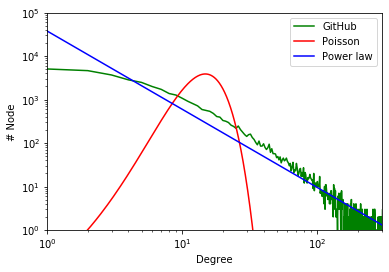

In [6]:
# Plot degree distribution
plt.xlabel("Degree")
plt.ylabel("# Node")
plt.xlim([1, 300])
plt.ylim([1, 100000])
plt.loglog(nx.degree_histogram(g), color='g', label='GitHub')

# Poisson distribution with the same mean.
avg_degree = 15.3317
total_n_nodes = 37700
poisson_x, poisson_y = poisson_data(avg_degree, high=300)
plt.plot(poisson_x, poisson_y * total_n_nodes, color='r', label='Poisson')

# Power law distribution with the same mean.
alpha = 2.07
power_law_x, power_law_y = power_law_data(1.8, high=300)
plt.plot(power_law_x, power_law_y * total_n_nodes, color='b', label='Power law')

plt.legend()

#### Observations

- The degree distribution of this data set is closer to power law.
- Recall that one major characteristic of scale-free networks is the presence of hubs (i.e. nodes of extremely high degree). It is the case for this dataset.
- Another major characteristic of scale-free networks is the "masses", a majority of nodes with super small degree. This dataset, however, looks more like something between Poisson and scale-free. That is, there aren't that many nodes with super small degrees as in scale-free networks. Instead, more nodes are distributed around the average degree ($\simeq 15$).
- Does the presence of hubs shrinks the average shortest path length? TODO

### Clustering coefficients

In [46]:
%%time
cc = nx.clustering(g)

CPU times: user 29.2 s, sys: 36.8 ms, total: 29.3 s
Wall time: 29.7 s


Average clusterng coefficient: 0.16753704480107584


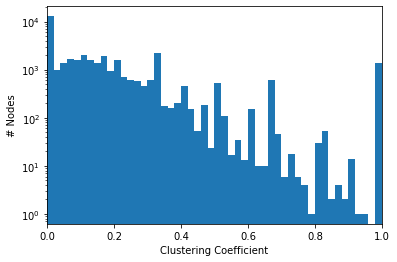

In [59]:
plt.hist(list(cc.values()), bins=50, log=True)
plt.xlabel('Clustering Coefficient')
plt.ylabel('# Nodes')
plt.xlim([0, 1])

print("Average clusterng coefficient:", np.mean(list(cc.values())))

One can notice from this histogram that there are considerable number of nodes with clustering coefficient being $1$, although not as many as that in the Facebook dataset.

Recall that the clustering coefficient is a measure of an "all-my-friends-know-each-other" property. This is sometimes described as "the friends of my friends are my friends".

The avereage clustering coefficient is around $0.168$. For comparison, this figure is $0.6$ in the Facebook dataset, $0.5$ in Enrom emails dataset, $0.3$ in CitNet, and $0.1$ in Erdos.

In [174]:
# Compute C(k) where k is node degree
def compute_ck(_g, _cc):
    _cc_deg = defaultdict(list)

    for node in _g.nodes():
        if type(node) is int:
            _local_cc = _cc[node]
        else:
            _local_cc = _cc[str(node)]
        _node_deg = _g.nodes[node]['deg']
        _cc_deg[_node_deg].append(_local_cc)
        
    _deg_cc_tuples = _cc_deg.items()
    _deg_cc_tuples = sorted(_deg_cc_tuples, key=lambda x: x[0])
    _deg_cc_tuples = [(t[0], np.mean(t[1])) for t in _deg_cc_tuples]
        
    _degs, _ccs = zip(*_deg_cc_tuples)
    return _degs, _ccs

We now proceed to explore $C(k)$, the average clustering coefficients of nodes with a given degree.

In [151]:
# C(k) of the dataset graph
degs, ccs = compute_ck(g, cc)

In [183]:
# Generate a random graph with the same degree sequence.
deg_seq = dict(g.degree()).values()
# rg = nx.random_degree_sequence_graph(deg_seq)  # Too slow...
rg = nx.havel_hakimi_graph(deg_seq)

# Update node attributes
for node in rg.nodes():
    rg.nodes[node]['deg'] = rg.degree[node]

In [184]:
%%time
cc_rg = nx.clustering(rg)
print("Average clusterng coefficient:", np.mean(list(cc_rg.values())))

Average clusterng coefficient: 0.6072727300841942
CPU times: user 23.2 s, sys: 141 ms, total: 23.3 s
Wall time: 23.7 s


In [185]:
degs_rg, ccs_rg = compute_ck(rg, cc_rg)

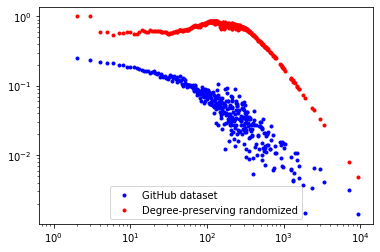

In [186]:
plt.loglog(degs, ccs, 'b.', label='GitHub dataset')
plt.loglog(degs_rg, ccs_rg, 'r.', label='Degree-preserving randomized')

plt.legend()

The shape of $C(k)$ of the GitHub dataset indicates that it might have **hierarchical modularity**. As stated in [here](http://networksciencebook.com/chapter/9/#hierarchical),

> The quantitative signature of this nested hierarchical modularity is the dependence of a node's clustering coefficient on the node's degree 
> $$C(k) \sim k^{-1}.$$

## Community Detection

In [6]:
def result_analysis(clusters, ordered=False):
    if ordered:
        clusters.sort(key=lambda x: len(x), reverse=True)
    
    for idx, c in enumerate(clusters):
        print('Community', idx)
        print('Community Size:', len(c))
        print('Percentage ML:', np.mean([int(g.nodes[n]['ml']) for n in c]))
        print()

###  Clauset-Newman-Moore Greedy Algorithm

In [16]:
def greedy_modularity(gml_filename, n_clusters=5):
    g_ig = ig.Graph.Read_GML(gml_filename)
    
    g_vertex_dendrogram = g_ig.community_fastgreedy()
    g_vertex_clustering = g_vertex_dendrogram.as_clustering(n_clusters)
    
    clusters = g_vertex_clustering.subgraphs()  # Returns a list
    clusters = [[v['label'] for v in c.vs] for c in clusters]
    
    return clusters

In [17]:
clusters = greedy_modularity('data/basic.gml')

In [26]:
with open('data/cnm-5-clusters.pickle', 'wb') as f:
    pickle.dump(clusters, f) 

In [38]:
result_analysis(clusters)

Community 0
Community Size: 15287
Percentage ML: 0.2850788251455485

Community 1
Community Size: 10994
Percentage ML: 0.3448244496998363

Community 2
Community Size: 9003
Percentage ML: 0.10207708541597245

Community 3
Community Size: 2103
Percentage ML: 0.28007608178792204

Community 4
Community Size: 313
Percentage ML: 0.26198083067092653



### Louvain Algorithm

In [29]:
def lauvain_modularity(g):
    partition = cmmnty.best_partition(g)
    d = defaultdict(list)
    for node in partition:
        d[partition[node]].append(node)
    return list(d.values())

In [30]:
clusters_lauvain = lauvain_modularity(g)

In [35]:
with open('data/lauvain-clusters.pickle', 'wb') as f:
    pickle.dump(clusters_lauvain, f) 

In [37]:
result_analysis(clusters_lauvain)

Community 0
Community Size: 1654
Percentage ML: 0.20133010882708585

Community 1
Community Size: 7292
Percentage ML: 0.20255074053757544

Community 2
Community Size: 7904
Percentage ML: 0.05237854251012146

Community 3
Community Size: 613
Percentage ML: 0.35889070146818924

Community 4
Community Size: 7762
Percentage ML: 0.7148930687967019

Community 5
Community Size: 5917
Percentage ML: 0.13807672807165794

Community 6
Community Size: 2433
Percentage ML: 0.17961364570489108

Community 7
Community Size: 407
Percentage ML: 0.24815724815724816

Community 8
Community Size: 2696
Percentage ML: 0.06157270029673591

Community 9
Community Size: 518
Percentage ML: 0.1833976833976834

Community 10
Community Size: 342
Percentage ML: 0.28654970760233917

Community 11
Community Size: 50
Percentage ML: 0.04

Community 12
Community Size: 6
Percentage ML: 1.0

Community 13
Community Size: 3
Percentage ML: 1.0

Community 14
Community Size: 3
Percentage ML: 0.0

Community 15
Community Size: 3
Percentag

### Random Walk

In [ ]:
def random_walk(gml_filename, n_clusters=5, steps=4):
    g_ig = ig.Graph.Read_GML(gml_filename)
    
    g_vertex_dendrogram = g_ig.community_walktrap(steps=steps)
    g_vertex_clustering = g_vertex_dendrogram.as_clustering(n_clusters)
    
    clusters = g_vertex_clustering.subgraphs()  # Returns a list
#     clusters = [[v['label'] for v in c.vs] for c in clusters]
    
    return clusters

clusters_random_walk = random_walk('data/basic.gml')

In [ ]:
with open('data/random_walk-n5-step4-clusters.pickle', 'wb') as f:
    pickle.dump(clusters_random_walk, f) 
    
result_analysis(clusters_random_walk)

### $k$-Clique Percolation

Given the overlapping nature of this dataset, let's give clique percolation a try.

In [4]:
# k = 3
communities = nx.algorithms.community.k_clique_communities(g, 3)

cnt = 0
for c in communities:
    cnt += 1
    
print(cnt)

KeyboardInterrupt: 

In [49]:
# k = 4
communities = nx.algorithms.community.k_clique_communities(g, 4)

cnt = 0
for c in communities:
    cnt += 1
    
print(cnt)

<generator object k_clique_communities at 0x7fd4ebe519a8>

In [ ]:
# k = 5
communities = nx.algorithms.community.k_clique_communities(g, 5)

cnt = 0
for c in communities:
    cnt += 1
    
print(cnt)

### Multilevel Algorithm (Blondel et al)

In [3]:
g_ig = ig.Graph.Read_GML('data/basic.gml')

In [4]:
vertex_clusterings = g_ig.community_multilevel(return_levels=True)

In [34]:
len(vertex_clusterings)

3

The total number of levels is 3.

In [37]:
clusters = vertex_clusterings[0].subgraphs()
print('Total # communities:', len(clusters), '\n')
clusters = [[v['label'] for v in c.vs] for c in clusters]
result_analysis(clusters, ordered=True)

Total # communities: 1628 

Community 0
Community Size: 5819
Percentage ML: 0.05413301254511085

Community 1
Community Size: 5653
Percentage ML: 0.09517070581991863

Community 2
Community Size: 4856
Percentage ML: 0.16289126853377264

Community 3
Community Size: 4631
Percentage ML: 0.8261714532498381

Community 4
Community Size: 2026
Percentage ML: 0.07403751233958539

Community 5
Community Size: 1119
Percentage ML: 0.22966934763181412

Community 6
Community Size: 1019
Percentage ML: 0.21786064769381747

Community 7
Community Size: 932
Percentage ML: 0.2939914163090129

Community 8
Community Size: 820
Percentage ML: 0.2146341463414634

Community 9
Community Size: 691
Percentage ML: 0.07959479015918958

Community 10
Community Size: 540
Percentage ML: 0.13148148148148148

Community 11
Community Size: 503
Percentage ML: 0.7435387673956262

Community 12
Community Size: 475
Percentage ML: 0.3178947368421053

Community 13
Community Size: 432
Percentage ML: 0.43287037037037035

Community 14
C

Percentage ML: 0.2

Community 188
Community Size: 5
Percentage ML: 0.0

Community 189
Community Size: 5
Percentage ML: 0.6

Community 190
Community Size: 5
Percentage ML: 0.0

Community 191
Community Size: 5
Percentage ML: 0.6

Community 192
Community Size: 5
Percentage ML: 0.0

Community 193
Community Size: 5
Percentage ML: 0.0

Community 194
Community Size: 5
Percentage ML: 0.4

Community 195
Community Size: 5
Percentage ML: 0.2

Community 196
Community Size: 5
Percentage ML: 1.0

Community 197
Community Size: 5
Percentage ML: 0.0

Community 198
Community Size: 5
Percentage ML: 0.0

Community 199
Community Size: 5
Percentage ML: 0.2

Community 200
Community Size: 5
Percentage ML: 0.2

Community 201
Community Size: 5
Percentage ML: 0.2

Community 202
Community Size: 5
Percentage ML: 0.0

Community 203
Community Size: 5
Percentage ML: 0.4

Community 204
Community Size: 5
Percentage ML: 0.4

Community 205
Community Size: 5
Percentage ML: 0.4

Community 206
Community Size: 5
Percentage M

Community 438
Community Size: 3
Percentage ML: 0.3333333333333333

Community 439
Community Size: 3
Percentage ML: 0.6666666666666666

Community 440
Community Size: 3
Percentage ML: 0.0

Community 441
Community Size: 3
Percentage ML: 0.0

Community 442
Community Size: 3
Percentage ML: 0.0

Community 443
Community Size: 3
Percentage ML: 0.3333333333333333

Community 444
Community Size: 3
Percentage ML: 0.0

Community 445
Community Size: 3
Percentage ML: 1.0

Community 446
Community Size: 3
Percentage ML: 0.0

Community 447
Community Size: 3
Percentage ML: 0.0

Community 448
Community Size: 3
Percentage ML: 1.0

Community 449
Community Size: 3
Percentage ML: 1.0

Community 450
Community Size: 3
Percentage ML: 1.0

Community 451
Community Size: 3
Percentage ML: 0.0

Community 452
Community Size: 3
Percentage ML: 0.6666666666666666

Community 453
Community Size: 3
Percentage ML: 1.0

Community 454
Community Size: 3
Percentage ML: 0.0

Community 455
Community Size: 3
Percentage ML: 0.0

Comm

Percentage ML: 0.6666666666666666

Community 708
Community Size: 3
Percentage ML: 0.0

Community 709
Community Size: 3
Percentage ML: 0.0

Community 710
Community Size: 3
Percentage ML: 0.6666666666666666

Community 711
Community Size: 3
Percentage ML: 0.0

Community 712
Community Size: 3
Percentage ML: 1.0

Community 713
Community Size: 3
Percentage ML: 0.0

Community 714
Community Size: 3
Percentage ML: 0.0

Community 715
Community Size: 3
Percentage ML: 0.3333333333333333

Community 716
Community Size: 3
Percentage ML: 0.0

Community 717
Community Size: 3
Percentage ML: 0.0

Community 718
Community Size: 3
Percentage ML: 0.0

Community 719
Community Size: 3
Percentage ML: 0.3333333333333333

Community 720
Community Size: 3
Percentage ML: 0.3333333333333333

Community 721
Community Size: 3
Percentage ML: 0.0

Community 722
Community Size: 3
Percentage ML: 0.0

Community 723
Community Size: 3
Percentage ML: 1.0

Community 724
Community Size: 3
Percentage ML: 0.0

Community 725
Communi

Percentage ML: 1.0

Community 1025
Community Size: 2
Percentage ML: 0.0

Community 1026
Community Size: 2
Percentage ML: 0.5

Community 1027
Community Size: 2
Percentage ML: 0.0

Community 1028
Community Size: 2
Percentage ML: 0.0

Community 1029
Community Size: 2
Percentage ML: 0.0

Community 1030
Community Size: 2
Percentage ML: 1.0

Community 1031
Community Size: 2
Percentage ML: 0.0

Community 1032
Community Size: 2
Percentage ML: 0.0

Community 1033
Community Size: 2
Percentage ML: 0.0

Community 1034
Community Size: 2
Percentage ML: 0.5

Community 1035
Community Size: 2
Percentage ML: 1.0

Community 1036
Community Size: 2
Percentage ML: 1.0

Community 1037
Community Size: 2
Percentage ML: 0.5

Community 1038
Community Size: 2
Percentage ML: 1.0

Community 1039
Community Size: 2
Percentage ML: 1.0

Community 1040
Community Size: 2
Percentage ML: 1.0

Community 1041
Community Size: 2
Percentage ML: 1.0

Community 1042
Community Size: 2
Percentage ML: 1.0

Community 1043
Community S

Community Size: 2
Percentage ML: 1.0

Community 1304
Community Size: 2
Percentage ML: 1.0

Community 1305
Community Size: 2
Percentage ML: 0.0

Community 1306
Community Size: 2
Percentage ML: 0.0

Community 1307
Community Size: 2
Percentage ML: 0.0

Community 1308
Community Size: 2
Percentage ML: 0.0

Community 1309
Community Size: 2
Percentage ML: 0.0

Community 1310
Community Size: 2
Percentage ML: 1.0

Community 1311
Community Size: 2
Percentage ML: 0.0

Community 1312
Community Size: 2
Percentage ML: 1.0

Community 1313
Community Size: 2
Percentage ML: 0.0

Community 1314
Community Size: 2
Percentage ML: 0.5

Community 1315
Community Size: 2
Percentage ML: 0.0

Community 1316
Community Size: 2
Percentage ML: 0.0

Community 1317
Community Size: 2
Percentage ML: 0.0

Community 1318
Community Size: 2
Percentage ML: 0.0

Community 1319
Community Size: 2
Percentage ML: 0.5

Community 1320
Community Size: 2
Percentage ML: 1.0

Community 1321
Community Size: 2
Percentage ML: 0.0

Communit

Percentage ML: 0.0

Community 1495
Community Size: 2
Percentage ML: 0.5

Community 1496
Community Size: 2
Percentage ML: 1.0

Community 1497
Community Size: 2
Percentage ML: 0.0

Community 1498
Community Size: 2
Percentage ML: 0.0

Community 1499
Community Size: 2
Percentage ML: 0.5

Community 1500
Community Size: 2
Percentage ML: 1.0

Community 1501
Community Size: 2
Percentage ML: 0.0

Community 1502
Community Size: 2
Percentage ML: 1.0

Community 1503
Community Size: 2
Percentage ML: 0.0

Community 1504
Community Size: 2
Percentage ML: 0.0

Community 1505
Community Size: 2
Percentage ML: 0.0

Community 1506
Community Size: 2
Percentage ML: 0.5

Community 1507
Community Size: 2
Percentage ML: 1.0

Community 1508
Community Size: 2
Percentage ML: 0.0

Community 1509
Community Size: 2
Percentage ML: 0.5

Community 1510
Community Size: 2
Percentage ML: 1.0

Community 1511
Community Size: 2
Percentage ML: 0.0

Community 1512
Community Size: 2
Percentage ML: 0.0

Community 1513
Community S

In [38]:
clusters = vertex_clusterings[1].subgraphs()
print('Total # communities:', len(clusters), '\n')
clusters = [[v['label'] for v in c.vs] for c in clusters]
result_analysis(clusters, ordered=True)

Total # communities: 82 

Community 0
Community Size: 7270
Percentage ML: 0.7455295735900963

Community 1
Community Size: 6547
Percentage ML: 0.06155491064609745

Community 2
Community Size: 6355
Percentage ML: 0.1861526357199056

Community 3
Community Size: 6316
Percentage ML: 0.10877137428752374

Community 4
Community Size: 2253
Percentage ML: 0.26187305814469597

Community 5
Community Size: 2253
Percentage ML: 0.0887705281846427

Community 6
Community Size: 1636
Percentage ML: 0.21638141809290953

Community 7
Community Size: 1579
Percentage ML: 0.09309689677010766

Community 8
Community Size: 966
Percentage ML: 0.17701863354037267

Community 9
Community Size: 560
Percentage ML: 0.04285714285714286

Community 10
Community Size: 546
Percentage ML: 0.3516483516483517

Community 11
Community Size: 462
Percentage ML: 0.17965367965367965

Community 12
Community Size: 309
Percentage ML: 0.255663430420712

Community 13
Community Size: 56
Percentage ML: 0.03571428571428571

Community 14
Comm

In [7]:
clusters = vertex_clusterings[2].subgraphs()
print('Total # communities:', len(clusters), '\n')
clusters = [[v['label'] for v in c.vs] for c in clusters]
result_analysis(clusters, ordered=True)

Total # communities: 31 

Community 0
Community Size: 7363
Percentage ML: 0.7424962651093304

Community 1
Community Size: 6575
Percentage ML: 0.06250950570342205

Community 2
Community Size: 6387
Percentage ML: 0.1891341788006889

Community 3
Community Size: 6326
Percentage ML: 0.10875750869427758

Community 4
Community Size: 3354
Percentage ML: 0.1520572450805009

Community 5
Community Size: 2836
Percentage ML: 0.08004231311706629

Community 6
Community Size: 2261
Percentage ML: 0.26404245908889873

Community 7
Community Size: 1004
Percentage ML: 0.1802788844621514

Community 8
Community Size: 577
Percentage ML: 0.35701906412478335

Community 9
Community Size: 474
Percentage ML: 0.1751054852320675

Community 10
Community Size: 378
Percentage ML: 0.26455026455026454

Community 11
Community Size: 55
Percentage ML: 0.38181818181818183

Community 12
Community Size: 40
Percentage ML: 0.475

Community 13
Community Size: 10
Percentage ML: 0.0

Community 14
Community Size: 6
Percentage ML: 1.

### Newman's Leading Eigenvector

In [40]:
vertex_clustering = g_ig.community_leading_eigenvector(clusters=None)

In [41]:
clusters = vertex_clustering.subgraphs()
print('Total # communities:', len(clusters), '\n')
clusters = [[v['label'] for v in c.vs] for c in clusters]
result_analysis(clusters, ordered=True)

Total # communities: 2 

Community 0
Community Size: 24030
Percentage ML: 0.2748231377444861

Community 1
Community Size: 13670
Percentage ML: 0.22933430870519386



How about letting the desired number of commuities be a very large number (say, 40)?

In [45]:
vertex_clustering = g_ig.community_leading_eigenvector(clusters=40)
clusters = vertex_clustering.subgraphs()
print('Total # communities:', len(clusters), '\n')
clusters = [[v['label'] for v in c.vs] for c in clusters]
result_analysis(clusters, ordered=True)

Total # communities: 2 

Community 0
Community Size: 24030
Percentage ML: 0.2748231377444861

Community 1
Community Size: 13670
Percentage ML: 0.22933430870519386



From [iGraph doc](https://igraph.org/python/doc/python-igraph.pdf):

> Note that the algorithm won’t split a community further if the signs of the leading eigenvector are all the same, so the actual number of discovered communities can be less than the desired one

### Infomap Method

Take very long time...

In [46]:
vertex_clustering = g_ig.community_infomap()
clusters = vertex_clustering.subgraphs()
print('Total # communities:', len(clusters), '\n')
clusters = [[v['label'] for v in c.vs] for c in clusters]
result_analysis(clusters, ordered=True)

KeyboardInterrupt: 

In [10]:
result_analysis(clusters)

Community 0
Community Size: 7363
Percentage ML: 0.7424962651093304

Community 1
Community Size: 6575
Percentage ML: 0.06250950570342205

Community 2
Community Size: 6387
Percentage ML: 0.1891341788006889

Community 3
Community Size: 6326
Percentage ML: 0.10875750869427758

Community 4
Community Size: 3354
Percentage ML: 0.1520572450805009

Community 5
Community Size: 2836
Percentage ML: 0.08004231311706629

Community 6
Community Size: 2261
Percentage ML: 0.26404245908889873

Community 7
Community Size: 1004
Percentage ML: 0.1802788844621514

Community 8
Community Size: 577
Percentage ML: 0.35701906412478335

Community 9
Community Size: 474
Percentage ML: 0.1751054852320675

Community 10
Community Size: 378
Percentage ML: 0.26455026455026454

Community 11
Community Size: 55
Percentage ML: 0.38181818181818183

Community 12
Community Size: 40
Percentage ML: 0.475

Community 13
Community Size: 10
Percentage ML: 0.0

Community 14
Community Size: 6
Percentage ML: 1.0

Community 15
Community 

In [15]:
for idx, c in enumerate(clusters):
    for node in c:
        g.nodes[node]['multilevel'] = idx

In [16]:
nx.write_gml(g, 'data/with_multilevel_comm_detect.gml')